In [1]:
import os
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
# 表示形式
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(precision=5, floatmode='maxprec')
np.set_printoptions(suppress=True)

In [3]:
my_df = pd.read_csv('../tf-notebooks/results/1024_tf_ver1/median_submission.csv')
my2_df = pd.read_csv('../tf-notebooks/results/1027_tf_ver1_pca10-ver2/median_submission.csv')

test_df = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

In [4]:
test_df['breath_id']=[i for i in range(4024000//80) for e in range(80)]

In [5]:
display(my_df.head())
display(my2_df.head())

display(test_df.head())

,id,pressure
0,1,6.32961
1,2,5.90779
2,3,7.10293
3,4,7.59505
4,5,9.14169


,id,pressure
0,1,6.25930
1,2,5.97810
2,3,7.17323
3,4,7.66535
4,5,9.21199


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.00000,0.00000,0
1,2,0,5,20,0.03190,7.51505,0
2,3,0,5,20,0.06383,14.65168,0
3,4,0,5,20,0.09575,21.23061,0
4,5,0,5,20,0.12764,26.32096,0


In [6]:
pred_df = pd.merge(my_df, my2_df, on='id', suffixes=['_my', '_good'])
pred_df['error'] = np.abs(pred_df['pressure_my']-pred_df['pressure_good'])
pred_df['breath_id'] = [i for i in range(4024000//80) for e in range(80)]

masked_df = pred_df
masked_df['error'] = masked_df.mask(test_df['u_out']==1)['error']

In [7]:
test_df.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.00000,0.00000,0
1,2,0,5,20,0.03190,7.51505,0
2,3,0,5,20,0.06383,14.65168,0
3,4,0,5,20,0.09575,21.23061,0
4,5,0,5,20,0.12764,26.32096,0


In [8]:
pred_df.head()

,id,pressure_my,pressure_good,error,breath_id
0,1,6.32961,6.25930,0.07030,0
1,2,5.90779,5.97810,0.07030,0
2,3,7.10293,7.17323,0.07030,0
3,4,7.59505,7.66535,0.07030,0
4,5,9.14169,9.21199,0.07030,0


In [9]:
masked_df

,id,pressure_my,pressure_good,error,breath_id
0,1,6.32961,6.25930,0.07030,0
1,2,5.90779,5.97810,0.07030,0
2,3,7.10293,7.17323,0.07030,0
3,4,7.59505,7.66535,0.07030,0
4,5,9.14169,9.21199,0.07030,0
...,...,...,...,...,...
4023995,4023996,6.18900,6.18900,NaN,50299
4023996,4023997,6.32961,6.25930,NaN,50299
4023997,4023998,6.39991,6.39991,NaN,50299
4023998,4023999,6.18900,6.11870,NaN,50299


In [10]:
np.array(pred_df['error']).reshape(-1, 80)

array([[0.0703 , 0.0703 , 0.0703 , ...,     nan,     nan,     nan],
       [0.     , 0.     , 0.0703 , ...,     nan,     nan,     nan],
       [0.0703 , 0.21091, 0.1406 , ...,     nan,     nan,     nan],
       ...,
       [0.1406 , 0.35151, 0.     , ...,     nan,     nan,     nan],
       [0.0703 , 0.     , 0.0703 , ...,     nan,     nan,     nan],
       [0.     , 0.0703 , 0.0703 , ...,     nan,     nan,     nan]])

In [11]:
MAE_id = masked_df.groupby('breath_id').agg(np.nanmean)['error']

In [12]:
MAE_id.head

<bound method NDFrame.head of breath_id
0       0.03628
1       0.01455
2       0.05333
3       0.10077
4       0.04121
          ...  
50295   0.11483
50296   0.09752
50297   0.05932
50298   0.06061
50299   0.01172
Name: error, Length: 50300, dtype: float64>

# Basic Exploration

In [13]:
MAE_id.describe()

count   50300.00000
mean        0.06519
std         0.09680
min         0.00000
25%         0.03394
50%         0.04848
75%         0.07257
max         3.83714
Name: error, dtype: float64

In [14]:
MAE_id.quantile(0.9)

0.10908953604499376

In [16]:
# np.log(MAE_id).hist(bins=100)

In [ ]:
MAE_id.where(MAE_id > 0.15).hist(bins=100)

In [17]:
MAE_id_sorted = MAE_id.sort_values(ascending=False)

In [18]:
MAE_id_sorted

breath_id
48284   3.83714
9571    3.74579
34669   3.66450
30477   3.53927
41576   3.51511
          ...  
33657   0.00234
49319   0.00234
37508   0.00000
38113   0.00000
9210    0.00000
Name: error, Length: 50300, dtype: float64

# worst predictions

cluster:48284 MAE: 3.837


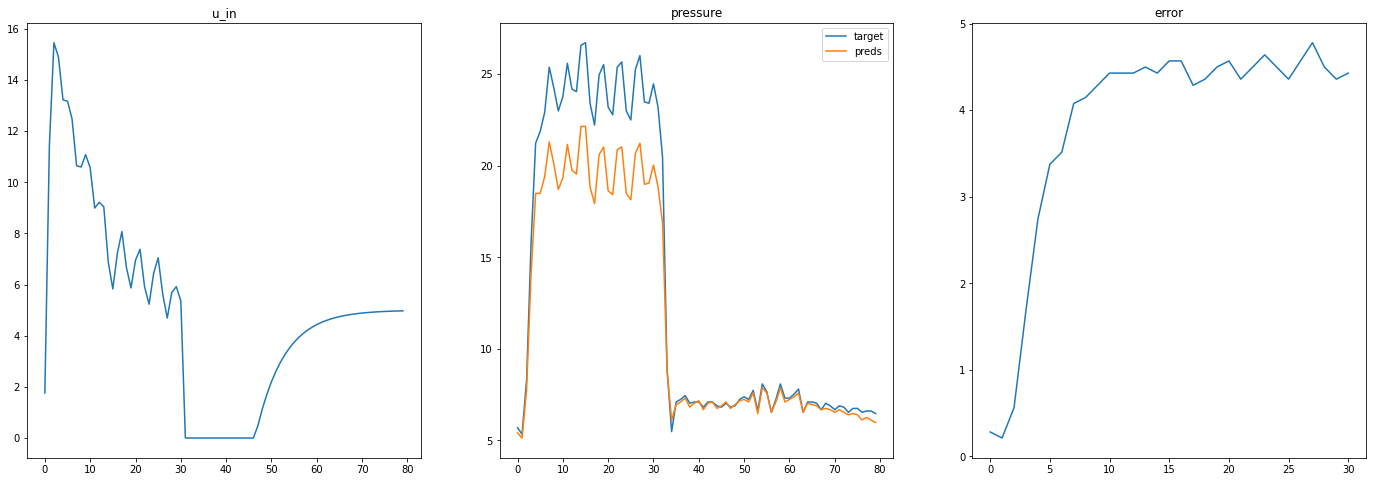

cluster:9571 MAE: 3.746


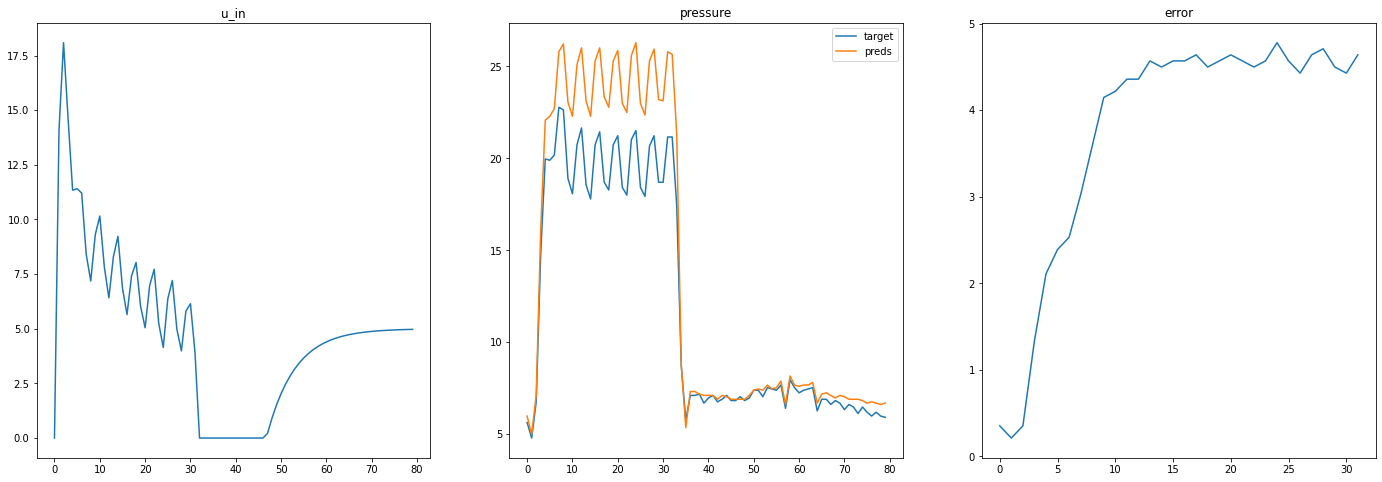

cluster:34669 MAE: 3.664


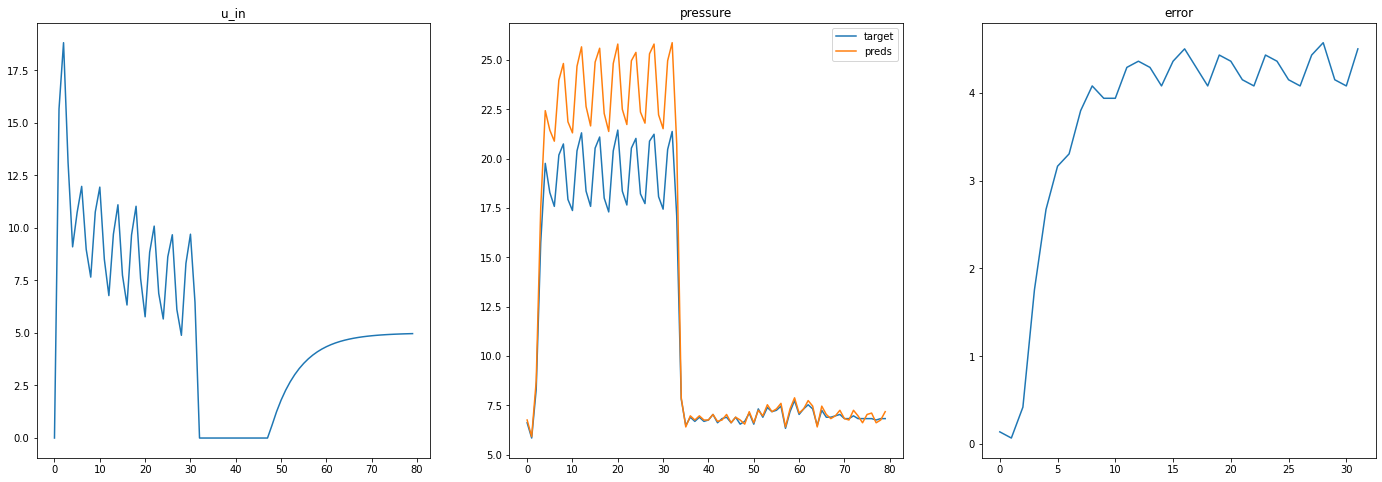

cluster:30477 MAE: 3.539


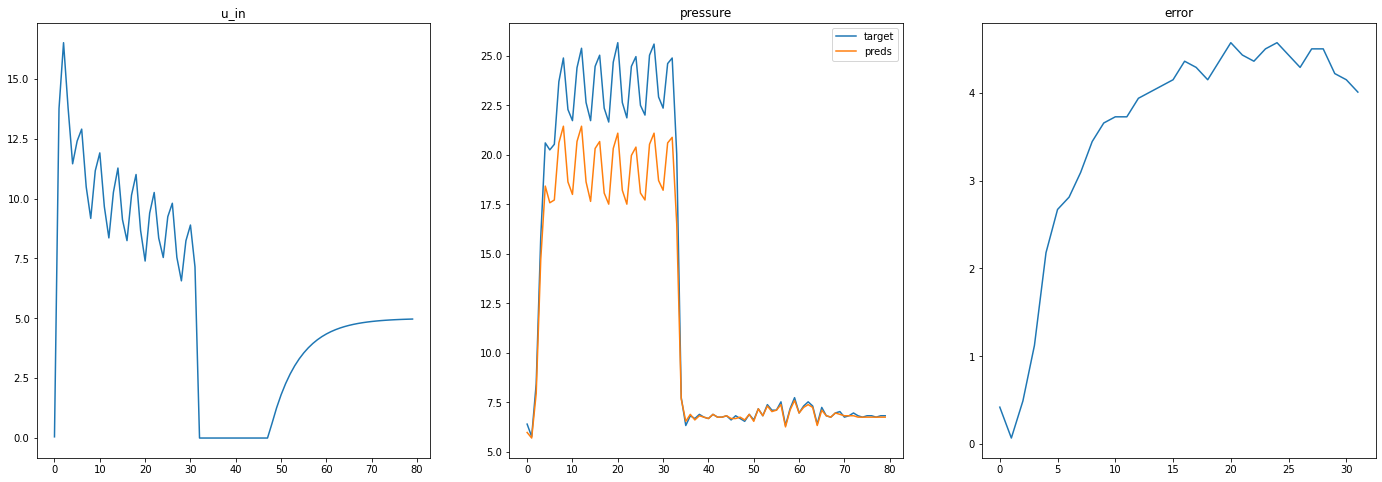

cluster:41576 MAE: 3.515


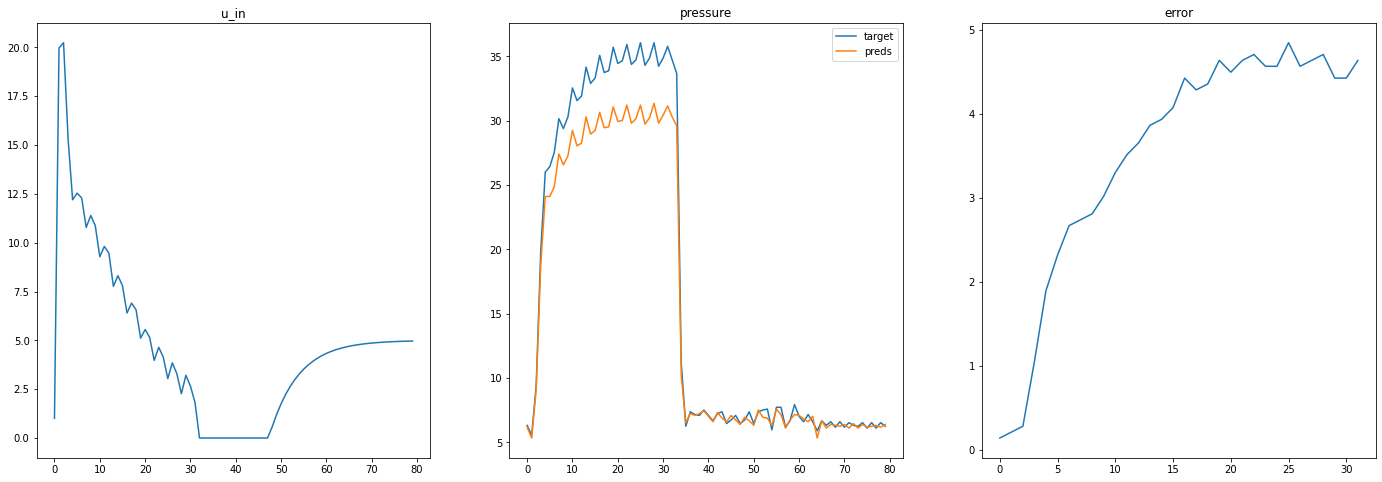

cluster:14237 MAE: 3.407


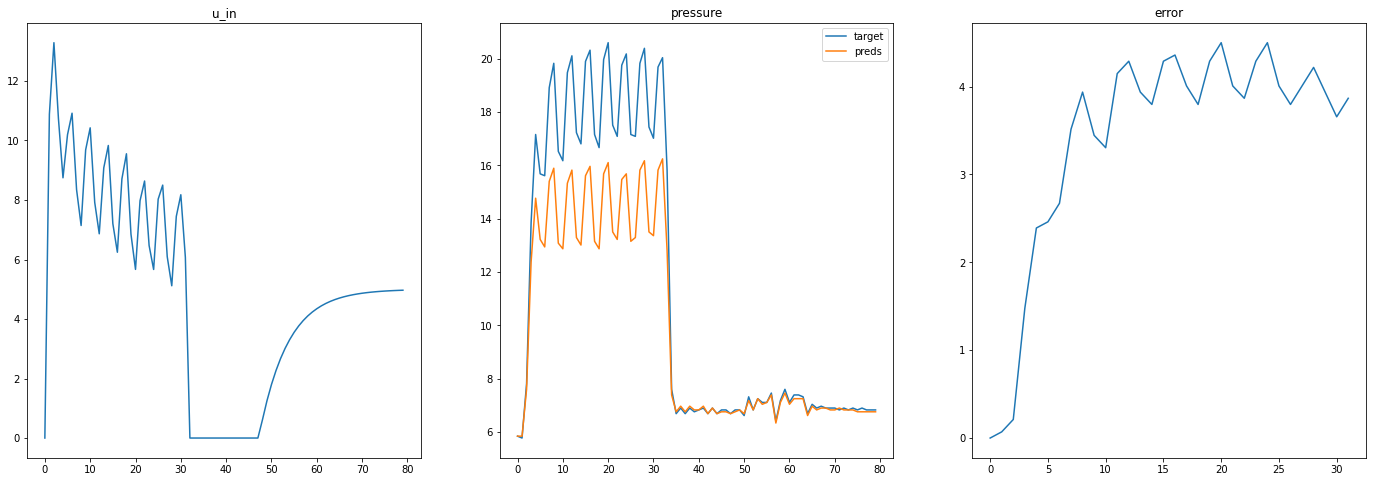

cluster:21626 MAE: 3.337


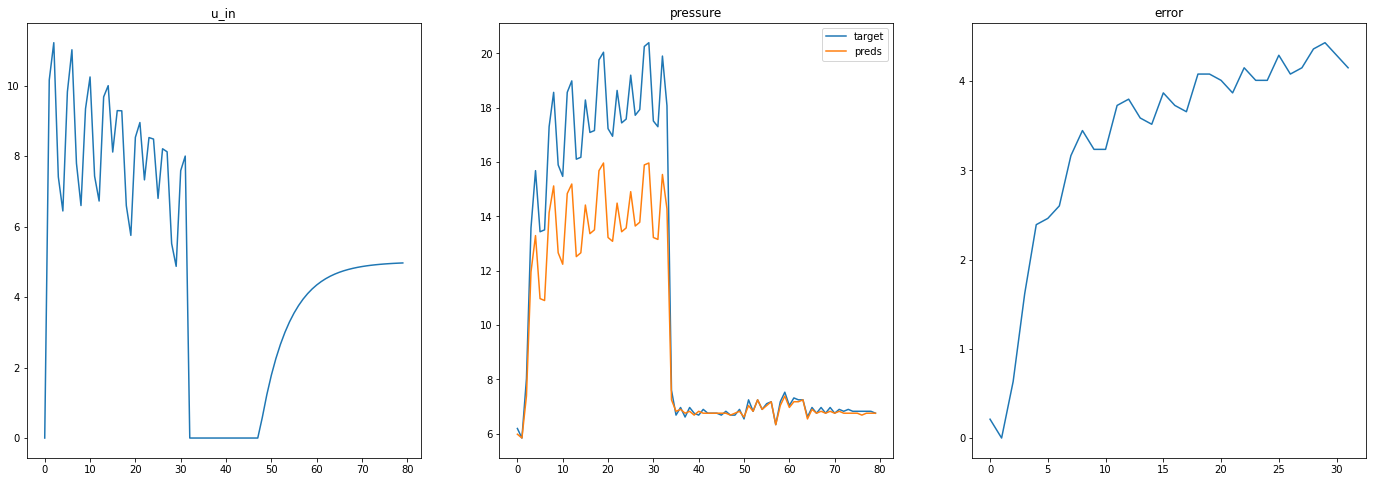

cluster:31127 MAE: 3.328


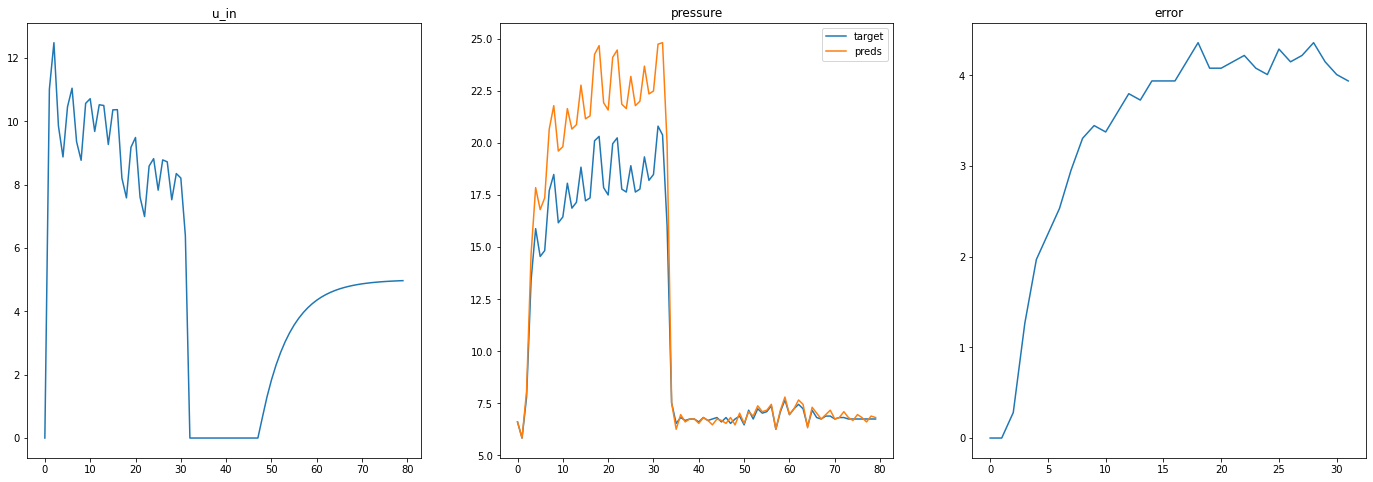

cluster:36885 MAE: 3.214


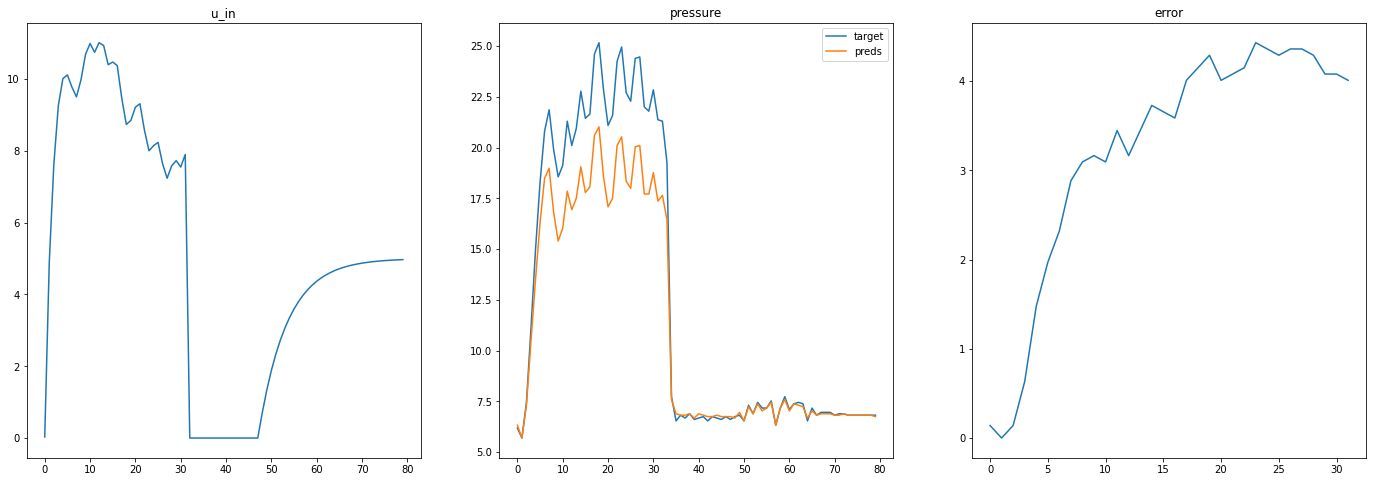

cluster:25286 MAE: 3.137


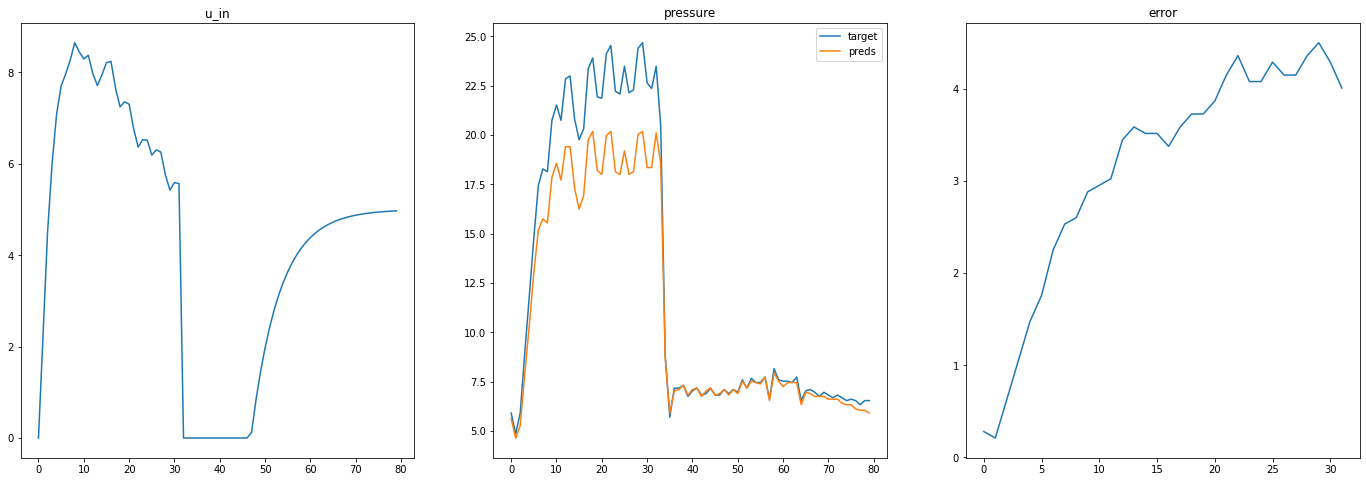

In [19]:
for i in MAE_id_sorted.index[:10]:
    ind = np.int(i)
    ind_labels = (MAE_id.index.values == i)
    
    print('cluster:'+str(i) + ' MAE: '+str(np.round(MAE_id_sorted[i],3)))

    plt.figure(figsize=(24,8))
    
    plt.subplot(1, 3, 1)
    plt.plot([i for i in range(80)], test_df[test_df['breath_id']==ind]['u_in']);
    plt.title('u_in')
    
    plt.subplot(1, 3, 2)
    plt.plot([i for i in range(80)], pred_df[pred_df['breath_id']==ind]['pressure_good'], label='target');
    plt.plot([i for i in range(80)], pred_df[pred_df['breath_id']==ind]['pressure_my'], label='preds');
    plt.legend()
    plt.title('pressure')
    
    plt.subplot(1, 3, 3)
    plt.plot([i for i in range(80)], pred_df[pred_df['breath_id']==ind]['error']);
    plt.title('error')
    
    plt.show()

In [ ]:
len(np.where(MAE_id > 0.2)[0])